### Compare multiple CNN architectures under controlled conditions and study generalization.

In [105]:
config = {
    "experiment_name": "cnn_experiment_v1",

    # model
    "models": ["cnn_l1", "cnn_l2", "cnn_l3"],
    "in_channels": 1,
    "num_classes": 10,

    # training
    "epochs": 10,
    "learning_rate": 0.001,
    "batch_size": 64
}


In [106]:
import pandas as pd

In [107]:
df_train = pd.read_csv('dataset/mnist_train.csv')
df_test = pd.read_csv('dataset/mnist_test.csv')


In [108]:
print(df_train.shape)
print(df_test.shape)

(59999, 785)
(9999, 785)


In [109]:
df_train.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
df_test.head()

,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
df_test.shape

(9999, 785)

In [112]:
train_labels = df_train.iloc[:, 0].values        # first column
train_images = df_train.iloc[:, 1:].values       # remaining 784 columns


test_labels = df_test.iloc[:, 0].values
test_images = df_test.iloc[:, 1:].values

In [113]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images,
    train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels
)

In [114]:
import torch

# Step 3: convert to torch ONCE

train_images = torch.tensor(train_images)
train_labels = torch.tensor(train_labels, dtype=torch.long)

val_images = torch.tensor(val_images)
val_labels = torch.tensor(val_labels, dtype=torch.long)

test_images = torch.tensor(test_images)
test_labels = torch.tensor(test_labels, dtype=torch.long)


In [115]:
test_images.shape

torch.Size([9999, 784])

In [116]:
# Step 4: reshape + normalize
train_images = train_images.reshape(-1, 1, 28, 28).float() / 255.0
val_images = val_images.reshape(-1,1,28,28).float()/255.0
test_images  = test_images.reshape(-1, 1, 28, 28).float() / 255.0


In [117]:
print("images shape:", train_images.shape)
print("labels shape:", train_labels.shape)

print("images shape:", val_images.shape)
print("labels shape:", val_labels.shape)

print("images shape:", test_images.shape)
print("labels shape:", test_labels.shape)


images shape: torch.Size([47999, 1, 28, 28])
labels shape: torch.Size([47999])
images shape: torch.Size([12000, 1, 28, 28])
labels shape: torch.Size([12000])
images shape: torch.Size([9999, 1, 28, 28])
labels shape: torch.Size([9999])


In [118]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_images,train_labels)
test_dataset = TensorDataset(test_images,test_labels)
val_dataset = TensorDataset(val_images,val_labels)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

In [119]:
import torch.nn as nn 
import torch.optim as optim
from tqdm import tqdm


In [120]:
#simple cnn level 1:
class cnn_l1(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv = nn.Conv2d(in_channels,8,kernel_size=3)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(8*26*26,num_classes)

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = x.view(x.size(0),-1)
        return self.fc(x)

In [121]:
#level 2:
class cnn_l2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels,16,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Linear(32*7*7,num_classes)

    def forward(self, x):
        x = self.features(x)
        # Convert 4D CNN output into 2D so it can be passed to nn.Linear
        x = x.view(x.size(0), -1) 
        return self.classifier(x)

In [122]:
# level 3:
class cnn_l3(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(in_channels,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7,128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128,num_classes)
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [128]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#string -> classes

MODEL_REGISTRY = {
    "cnn_l1": cnn_l1,
    "cnn_l2": cnn_l2,
    "cnn_l3": cnn_l3
}


#model builder
def build_model(model,config):

    model = MODEL_REGISTRY[model]

    model = model(in_channels=config["in_channels"],
                  num_classes=config["num_classes"]
    ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    return model, criterion, optimizer

Using device: cuda


In [129]:
#training loop
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(loader):
        images,labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)

In [130]:
def eval_c(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy


In [131]:
import matplotlib.pyplot as plt

def plot_g(train, val, model_name):
    epochs_range = range(1, len(train) + 1)

    plt.figure()
    plt.plot(epochs_range, train, label="Train Loss")
    plt.title(f"{model_name} - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(epochs_range, val, label="Val Accuracy")
    plt.title(f"{model_name} - Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()



Training cnn_l1


  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [00:02<00:00, 715.14it/s]


Epoch 1 | Train Loss: 0.2767 | Val Acc: 0.9571


100%|██████████| 1500/1500 [00:02<00:00, 701.51it/s]


Epoch 2 | Train Loss: 0.1092 | Val Acc: 0.9688


100%|██████████| 1500/1500 [00:02<00:00, 735.39it/s]


Epoch 3 | Train Loss: 0.0773 | Val Acc: 0.9729


100%|██████████| 1500/1500 [00:02<00:00, 718.98it/s]


Epoch 4 | Train Loss: 0.0613 | Val Acc: 0.9728


100%|██████████| 1500/1500 [00:02<00:00, 675.68it/s]


Epoch 5 | Train Loss: 0.0507 | Val Acc: 0.9758


100%|██████████| 1500/1500 [00:01<00:00, 768.45it/s]


Epoch 6 | Train Loss: 0.0434 | Val Acc: 0.9764


100%|██████████| 1500/1500 [00:02<00:00, 691.94it/s]


Epoch 7 | Train Loss: 0.0363 | Val Acc: 0.9738


100%|██████████| 1500/1500 [00:02<00:00, 693.42it/s]


Epoch 8 | Train Loss: 0.0307 | Val Acc: 0.9754


100%|██████████| 1500/1500 [00:02<00:00, 690.54it/s]


Epoch 9 | Train Loss: 0.0270 | Val Acc: 0.9758


100%|██████████| 1500/1500 [00:01<00:00, 751.32it/s]


Epoch 10 | Train Loss: 0.0219 | Val Acc: 0.9758
Test Accuracy for <class '__main__.cnn_l3'>: 0.9786


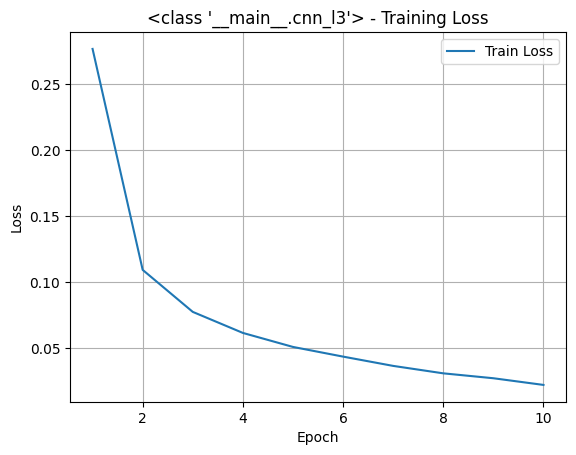

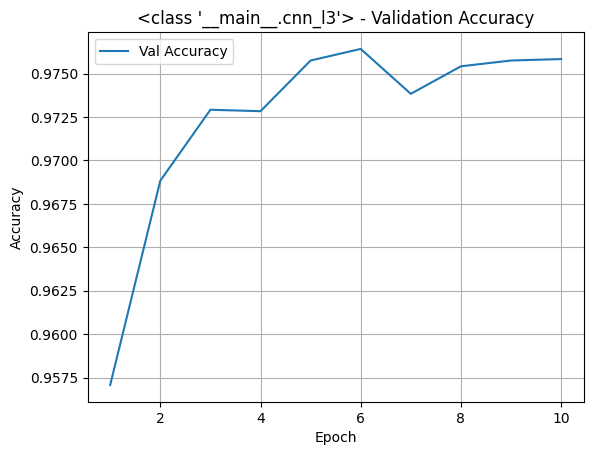


Training cnn_l2


100%|██████████| 1500/1500 [00:02<00:00, 642.71it/s]


Epoch 1 | Train Loss: 0.2358 | Val Acc: 0.9738


100%|██████████| 1500/1500 [00:02<00:00, 659.27it/s]


Epoch 2 | Train Loss: 0.0735 | Val Acc: 0.9748


100%|██████████| 1500/1500 [00:02<00:00, 650.03it/s]


Epoch 3 | Train Loss: 0.0537 | Val Acc: 0.9802


100%|██████████| 1500/1500 [00:02<00:00, 669.09it/s]


Epoch 4 | Train Loss: 0.0429 | Val Acc: 0.9839


100%|██████████| 1500/1500 [00:02<00:00, 614.80it/s]


Epoch 5 | Train Loss: 0.0359 | Val Acc: 0.9855


100%|██████████| 1500/1500 [00:02<00:00, 552.11it/s]


Epoch 6 | Train Loss: 0.0298 | Val Acc: 0.9806


100%|██████████| 1500/1500 [00:02<00:00, 603.72it/s]


Epoch 7 | Train Loss: 0.0245 | Val Acc: 0.9861


100%|██████████| 1500/1500 [00:02<00:00, 667.73it/s]


Epoch 8 | Train Loss: 0.0219 | Val Acc: 0.9860


100%|██████████| 1500/1500 [00:02<00:00, 615.48it/s]


Epoch 9 | Train Loss: 0.0193 | Val Acc: 0.9864


100%|██████████| 1500/1500 [00:02<00:00, 564.79it/s]


Epoch 10 | Train Loss: 0.0168 | Val Acc: 0.9850
Test Accuracy for <class '__main__.cnn_l3'>: 0.9877


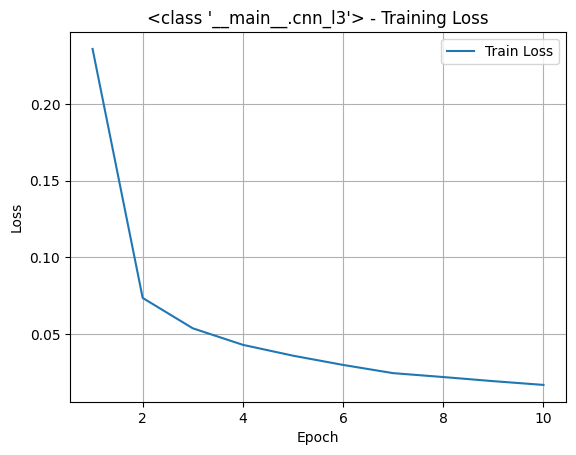

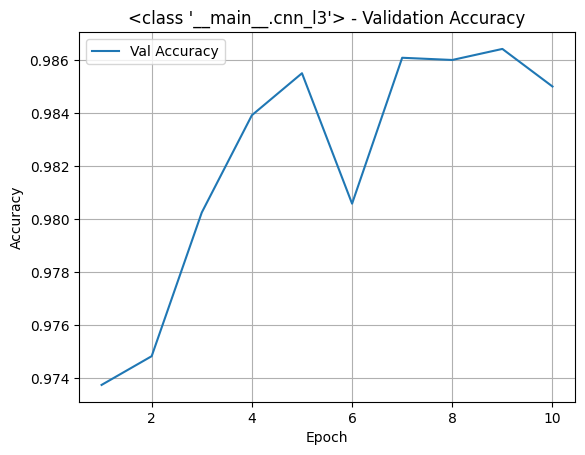


Training cnn_l3


100%|██████████| 1500/1500 [00:03<00:00, 428.54it/s]


Epoch 1 | Train Loss: 0.2564 | Val Acc: 0.9814


100%|██████████| 1500/1500 [00:03<00:00, 438.38it/s]


Epoch 2 | Train Loss: 0.1192 | Val Acc: 0.9848


100%|██████████| 1500/1500 [00:03<00:00, 446.14it/s]


Epoch 3 | Train Loss: 0.0894 | Val Acc: 0.9864


100%|██████████| 1500/1500 [00:03<00:00, 439.31it/s]


Epoch 4 | Train Loss: 0.0758 | Val Acc: 0.9885


100%|██████████| 1500/1500 [00:03<00:00, 447.26it/s]


Epoch 5 | Train Loss: 0.0661 | Val Acc: 0.9887


100%|██████████| 1500/1500 [00:03<00:00, 441.17it/s]


Epoch 6 | Train Loss: 0.0571 | Val Acc: 0.9884


100%|██████████| 1500/1500 [00:03<00:00, 452.84it/s]


Epoch 7 | Train Loss: 0.0499 | Val Acc: 0.9883


100%|██████████| 1500/1500 [00:03<00:00, 434.02it/s]


Epoch 8 | Train Loss: 0.0430 | Val Acc: 0.9892


100%|██████████| 1500/1500 [00:03<00:00, 442.02it/s]


Epoch 9 | Train Loss: 0.0415 | Val Acc: 0.9912


100%|██████████| 1500/1500 [00:03<00:00, 435.77it/s]


Epoch 10 | Train Loss: 0.0349 | Val Acc: 0.9907
Test Accuracy for <class '__main__.cnn_l3'>: 0.9920


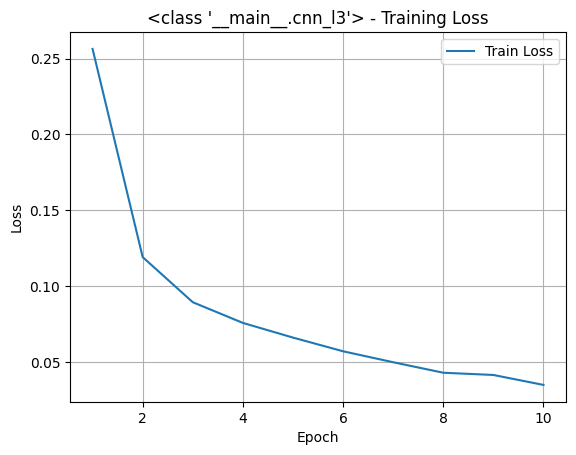

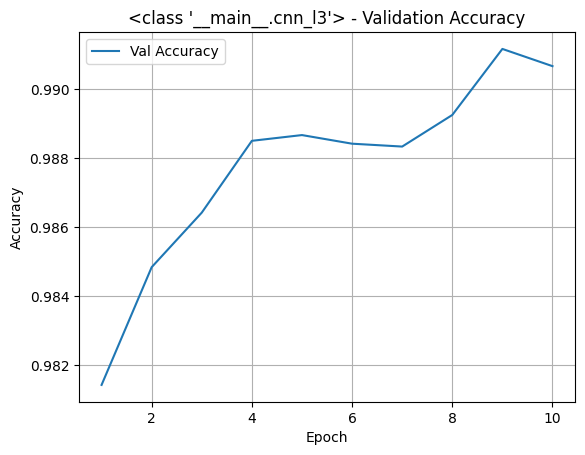

In [132]:
models = [cnn_l1, cnn_l2, cnn_l3]

epochs = 10  


for model_name in config["models"]:
    print(f"\nTraining {model_name}")
    model, criterion, optimizer = build_model(model_name, config)

    history_val = []
    history_train = []

    for epoch in range(epochs):
        loss = train(model, train_loader, criterion, optimizer)
        val_acc = eval_c(model, val_loader)
        print(
            f"Epoch {epoch+1} | "
            f"Train Loss: {loss:.4f} | "
            f"Val Acc: {val_acc:.4f}"
        )
        history_val.append(val_acc)
        history_train.append(loss)

    acc = eval_c(model, test_loader)
    # IMPORTANT: eval() must be called on the TRAINED MODEL INSTANCE, not the class
    print(f"Test Accuracy for {model_class}: {acc:.4f}")
    plot_g(history_train,history_val, model_class)
    